In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as c
import matplotlib.patches as mpatches

plt.rc("font", family="serif", size=16)
plt.rc("mathtext", fontset="cm")
plt.rc("lines", lw=2)

In [4]:
u = 1.
r = 1.

def f(phi, a):
    p2 = phi[0]**2 + phi[1]**2
    mu1 = -r*phi[0] + a*phi[1] + u * p2 * phi[0]
    mu2 = -r*phi[1] - a*phi[0] + u * p2 * phi[1]
    return np.array([mu1, mu2])


def l1(phi, r, a): 
    p2 = phi[0]**2 + phi[1]**2
    return -r + 2*u*p2 - np.sqrt( (u*p2)**2 - a**2 +0j)

def l2(phi, r, a): 
    p2 = phi[0]**2 + phi[1]**2
    return -r + 2*u*p2 + np.sqrt( (u*p2)**2 - a**2 +0j )

xm = lambda r, a: ( 2*r - np.sqrt(r**2 - 3*a**2 + 0j) )/3
xp = lambda r, a: ( 2*r + np.sqrt(r**2 - 3*a**2 + 0j) )/3

def Crx(x1, x2, a, r):
    mask1 = l1([x1, x2], r, a).real<0
    mask2 = l2([x1, x2], r, a).real<0
    mask = np.logical_xor(mask1, mask2)
    return np.ma.masked_where(mask==0, mask)

def Cr(x1, x2, a, r):
    mask1 = l1([x1, x2], r, a).real<0
    mask2 = l2([x1, x2], r, a).real<0
    mask = np.logical_or(mask1, mask2)
    return np.ma.masked_where(mask==0, mask)

def Ci(x1, x2, a, r):
    C = l1([x1, x2], r, a).imag
    return np.ma.masked_where(C==0, C)


def G(x1, x2, r, a):
    p = np.sqrt(x1**2 + x2**2)
    G11 = -r + u * (p**2+2*x1**2)
    G22 = -r + u * (p**2+2*x2**2)
    G12 = +a + 2*u*x1*x2
    G21 = -a + 2*u*x1*x2
    g = np.array([[G11, G12], [G21, G22]])
    g = np.moveaxis(g, (2, 3), (0, 1))
    return eig(g)[1]

In [7]:
k1, k2 = np.sqrt(3), 2

def plot(n, m, a, r, ax, x1, x2, k):

    ax[n//m, n%m].pcolormesh(x1, x2, Ci(x1, x2, a, r), alpha=.1, linewidth=0, antialiased=True, cmap=c.ListedColormap(['blue']), label="$\mathcal C_\Im$")
    ax[n//m, n%m].pcolormesh(x1, x2, Cr(x1, x2, a, r), alpha=.1, linewidth=0, antialiased=True, cmap=c.ListedColormap(['red']))

    v1, v2 = - f([x1, x2], a)
    l = np.sqrt(v1**2 + v2**2)
    ax[n//m, n%m].streamplot(x1, x2, v1, v2, color=l, density=1., linewidth=1.5)
    ax[n//m, n%m].set_title(
        "$\\alpha={:.2f}, r={:.2f}$".format(a, r) 
        # +  ",    $r>\\sqrt{3}\\alpha: $" + str(r>np.sqrt(3)*a) 
        # + ",    $r<2\\alpha: $" + str(r<2*a)
    )

    theta = np.linspace(0, 2*np.pi, 100)

    handles = []
    labels = []
    if r>np.sqrt(3)*a:
        p1 = np.sqrt(xm(r, a)/u)
        assert p1.imag == 0
        p1 = p1.real
        a1 = ax[n//m, n%m].plot(p1*np.cos(theta), p1*np.sin(theta), 'r--')
        p2 = np.sqrt(xp(r, a)/u)
        assert p2.imag == 0
        p2 = p2.real
        a2 = ax[n//m, n%m].plot(p2*np.cos(theta), p2*np.sin(theta), 'k--')
        handles = [a1[0], a2[0]]
        labels = ["$|\\varphi|_-$", "$|\\varphi|_+$"]

    ax[n//m, n%m].set_xlim(-k, k)
    ax[n//m, n%m].set_ylim(-k, k)
    handles.append(mpatches.Patch(color='blue',alpha=.1))
    handles.append(mpatches.Patch(color='red',alpha=.1))
    labels.append("$\\mathcal{C}_\Im$")
    labels.append("$\\mathcal{C}_\Re$")
    ax[n//m, n%m].legend(handles, labels,loc=1)

    ax[n//m, n%m].set_xlabel("$\\varphi_1$")
    ax[n//m, n%m].set_ylabel("$\\varphi_2$")

    return ax

def plot_m(n, m, a, r, ax, x, k):

    ax[n//m, n%m].plot(x, l1([x, 0], r, a).real, 'k-', label='$\\Re \\lambda_-$')
    ax[n//m, n%m].plot(x, l2([x, 0], r, a).real, 'r--', label='$\\Re\\lambda_+$')
    ax[n//m, n%m].plot(x, l1([x, 0], r, a).imag, 'g-.', alpha=.4, label='$\\Im\\lambda_-$')
    ax[n//m, n%m].plot(x, l2([x, 0], r, a).imag, 'b-.', alpha=.4, label='$\\Im\\lambda_+$')
    ax[n//m, n%m].plot(x, 0*x, 'k--', alpha=.4, lw=.2)

    if r>np.sqrt(3)*a:
        ax[n//m, n%m].plot(np.sqrt(xp(r, a)).real, 0, 'ko', lw=.2, label='$|\\varphi|_+$')
        ax[n//m, n%m].plot(np.sqrt(xm(r, a)).real, 0, 'ko', lw=.2, label='$|\\varphi|_-$')
        ax[n//m, n%m].plot(np.sqrt(xm(r, a)).real*np.array([1,1]), [-1, 1], 'k--', lw=.8, alpha=.5)

    ax[n//m, n%m].set_title(
        "$\\alpha={:.2f}, r={:.2f}$".format(a, r) 
        # +  ",    $r>\\sqrt{3}\\alpha: $" + str(r>np.sqrt(3)*a) 
        # + ",    $r<2\\alpha: $" + str(r<2*a)
    )
    ax[n//m, n%m].set_xlim(np.min(x), np.max(x))
    ax[n//m, n%m].set_ylim(-1, 1)
    ax[n//m, n%m].legend(loc=2)

    ax[n//m, n%m].set_xlabel("$|\\varphi|$")
    ax[n//m, n%m].set_ylabel("$\\lambda$")

    return ax

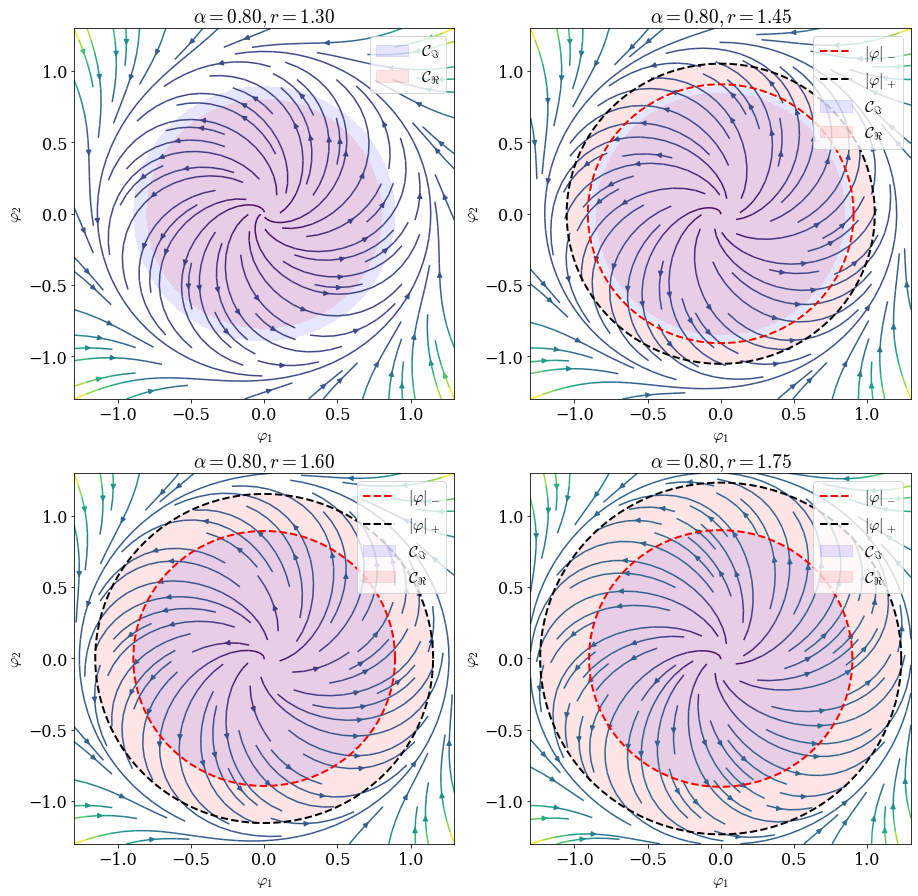

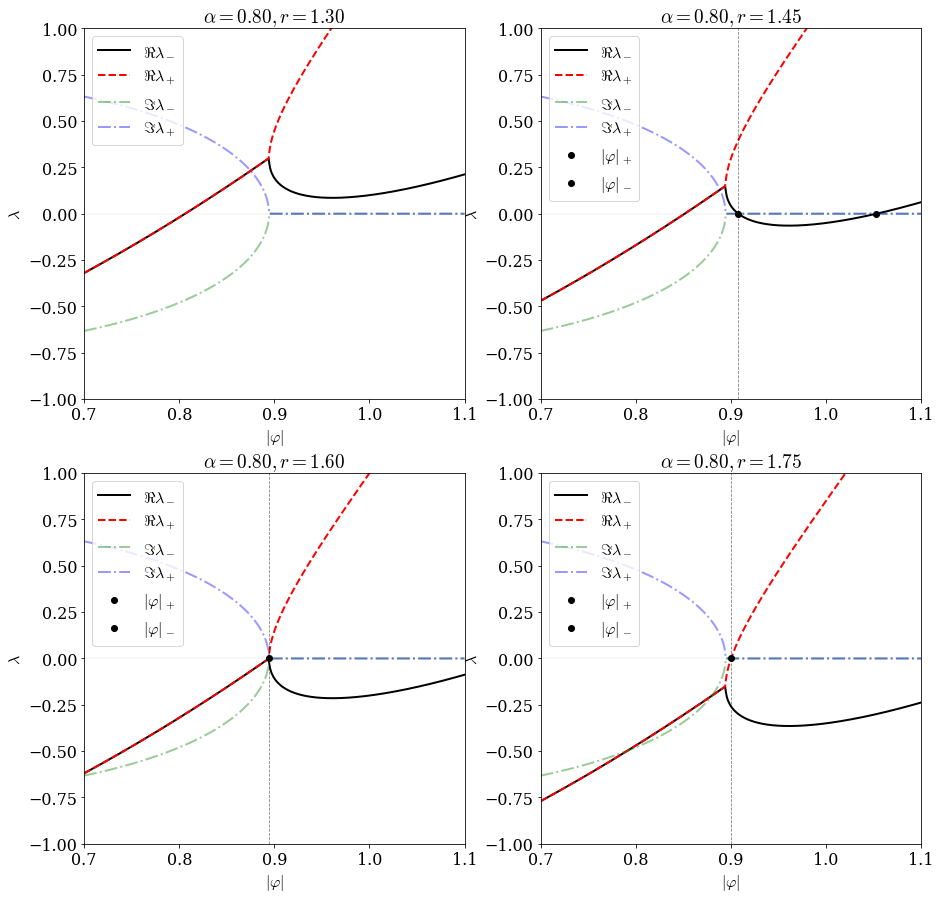

In [8]:
N = 500
k = 1.3

x10, x20 = np.linspace(-k, k, N), np.linspace(-k, k, N)
x1, x2 = np.meshgrid(x10, x20)

x = np.linspace(.7, 1.1, N)

m = 2

a = .8
rr = np.linspace(k1*a-.1, k2*a+.25, m**2)
rr = np.linspace(1.3, 1.75, m**2)

fig1, ax1 = plt.subplots(m, m, figsize=(15, 15))
fig2, ax2 = plt.subplots(m, m, figsize=(15, 15))
for n, r in enumerate(rr):
    plot(n, m, a, r, ax1, x1, x2, k)
    plot_m(n, m, a, r, ax2, x, k)

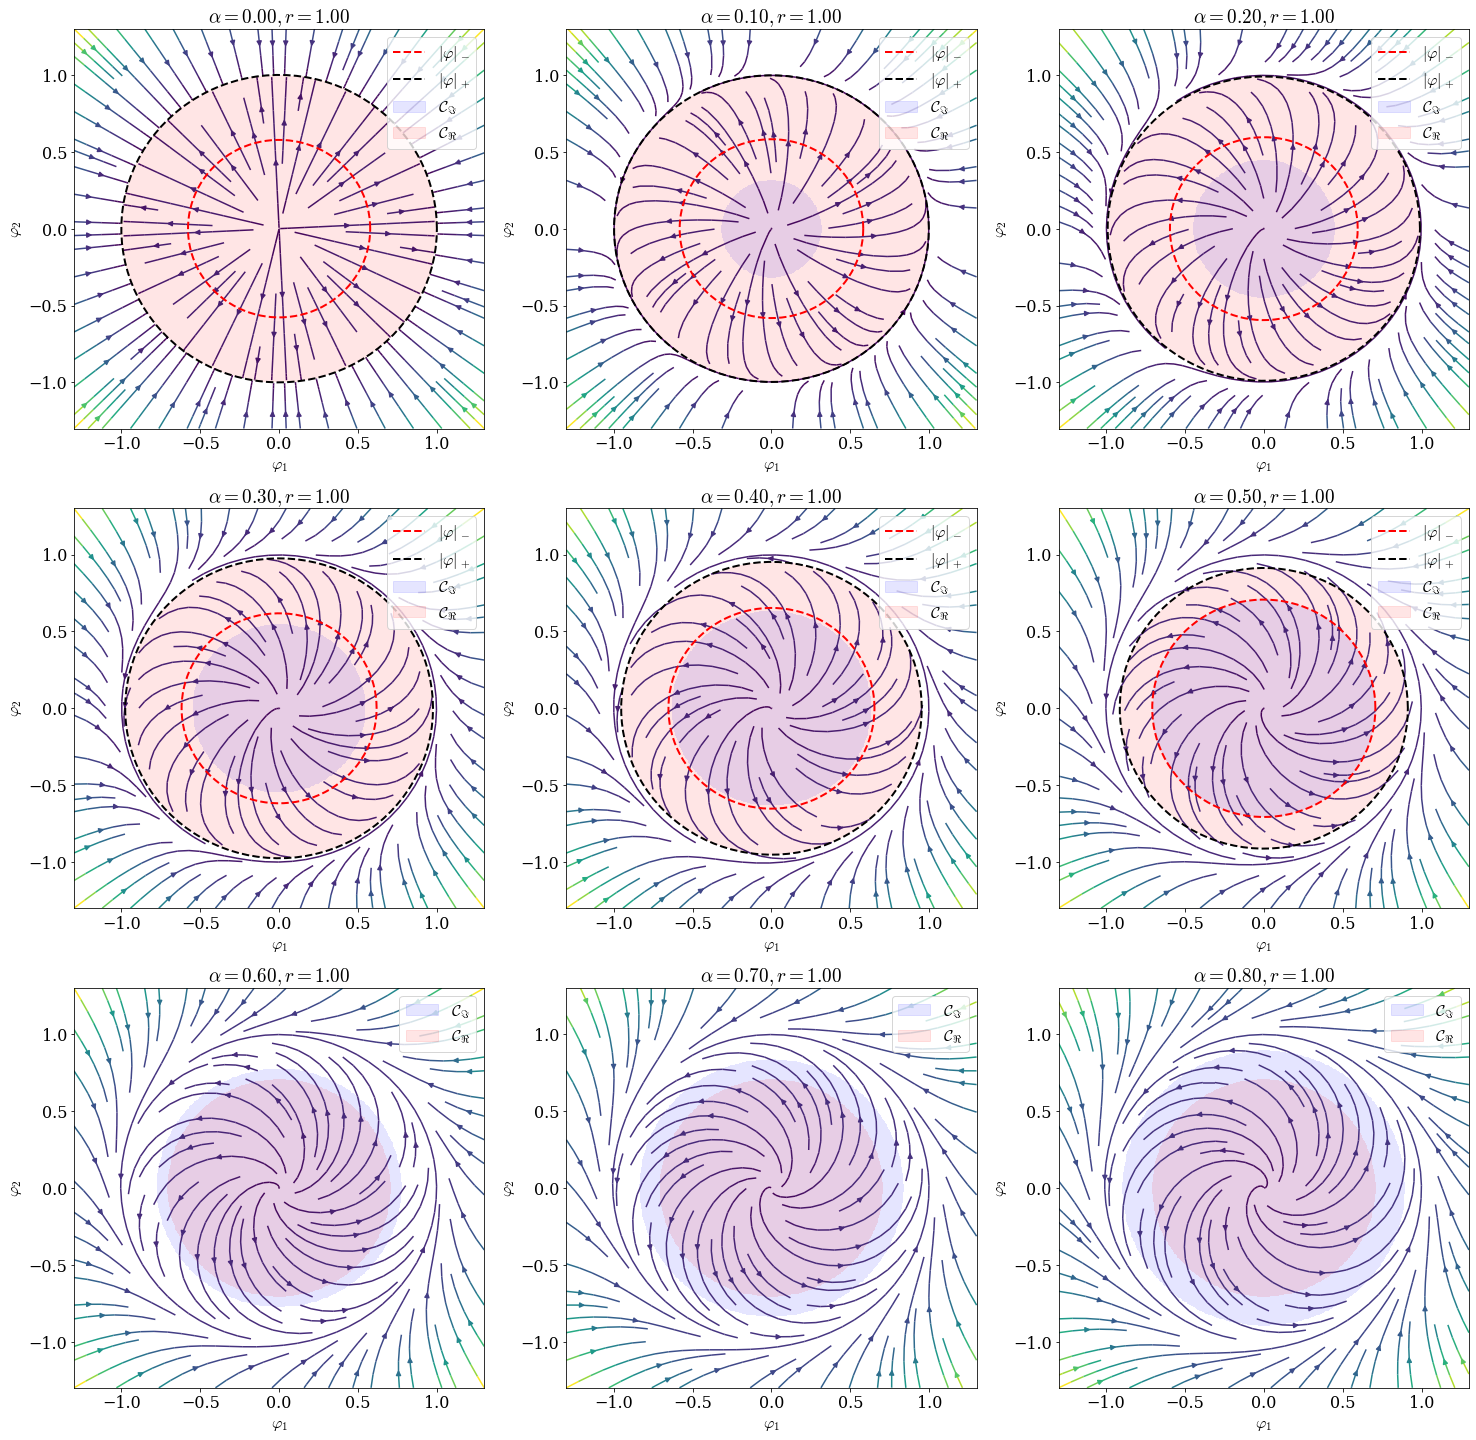

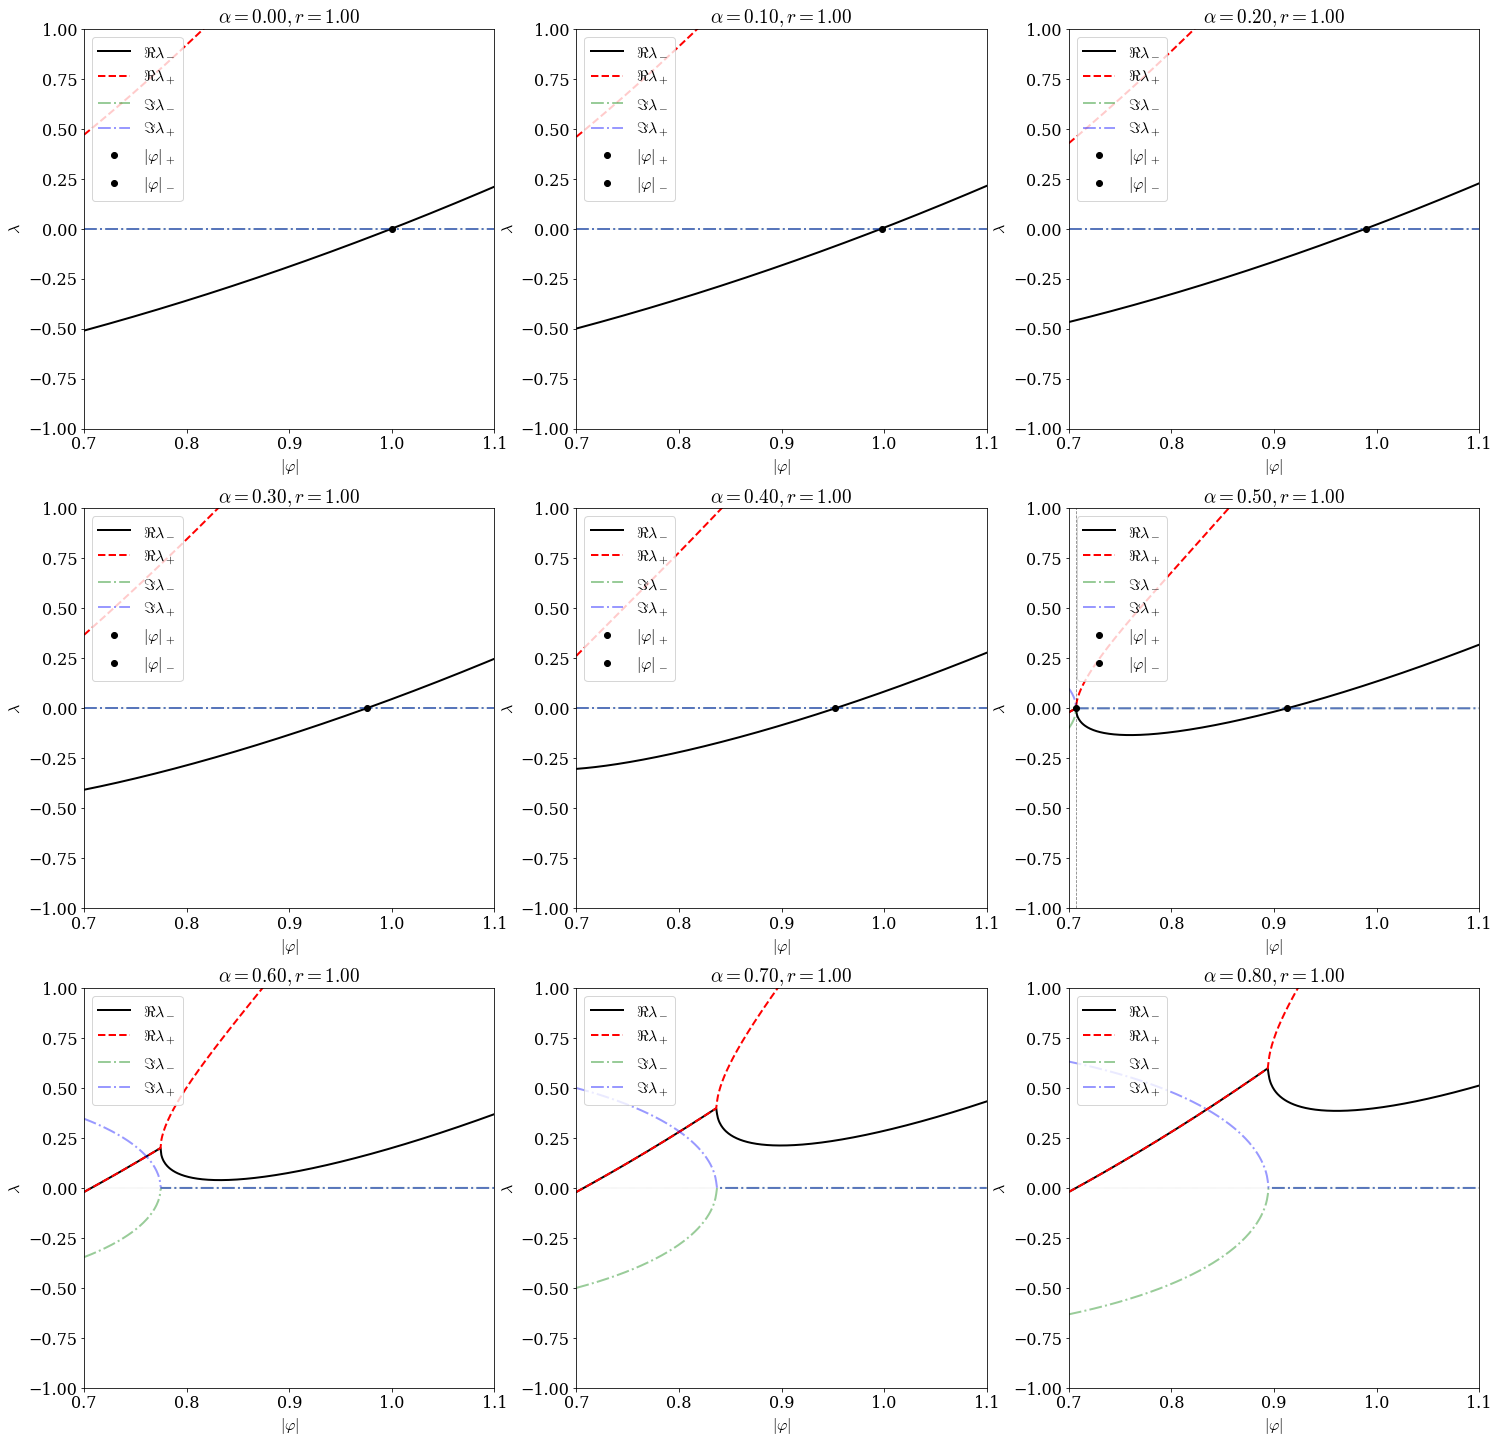

In [12]:
r = 1.
aa = np.linspace(0, .8, 9)

m = 3

fig1, ax1 = plt.subplots(m, m, figsize=(25, 25))
fig2, ax2 = plt.subplots(m, m, figsize=(25, 25))
for n, a in enumerate(aa):
    plot(n, m, a, r, ax1, x1, x2, k)
    plot_m(n, m, a, r, ax2, x, k)

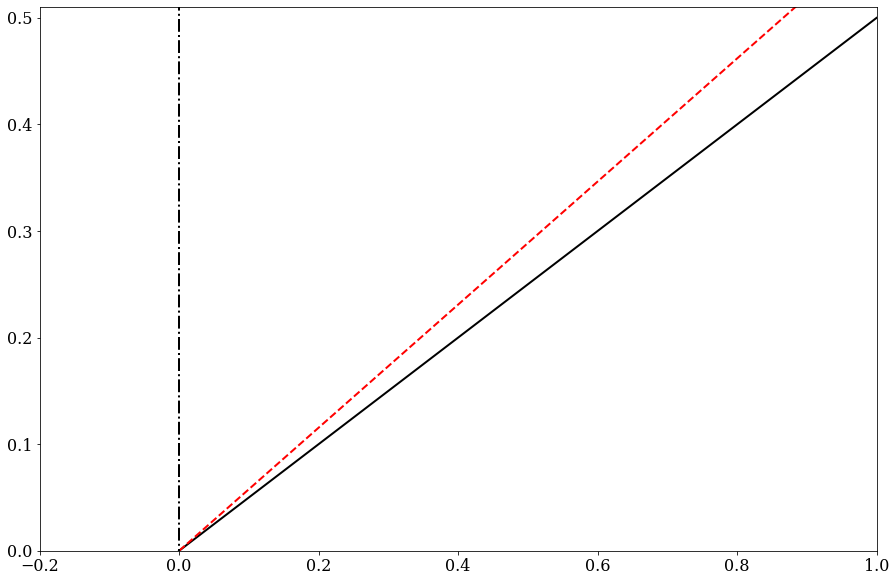

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))

r = np.linspace(0, 1, 1000)
ax.plot(r, r/2, "k-")
ax.plot(r, r/np.sqrt(3), 'r--')
ax.plot([0, 0], [-.1, .6], "k-.")

ax.set_xlim([-.2, 1])
ax.set_ylim([-.0, .51])

plt.show()

/tmp/ipykernel_331768/920273256.py:7: RuntimeWarning: invalid value encountered in sqrt
  xi = lambda r: 1 / np.sqrt(2 / 3) / np.sqrt( - th -  2 * np.sqrt(th**2 - 3 ) )
/tmp/ipykernel_331768/920273256.py:7: RuntimeWarning: divide by zero encountered in true_divide
  xi = lambda r: 1 / np.sqrt(2 / 3) / np.sqrt( - th -  2 * np.sqrt(th**2 - 3 ) )


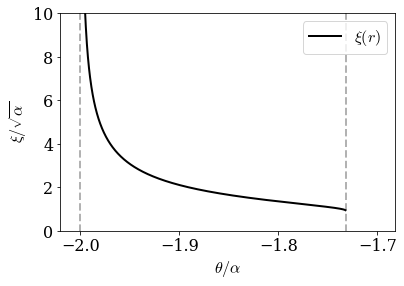

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))

a = 1

th = np.linspace(-np.sqrt(3), -2, 1000)

xi = lambda r: 1 / np.sqrt(2 / 3) / np.sqrt( - th -  2 * np.sqrt(th**2 - 3 ) )

ax.plot(th, xi(th), "k-", label="$\\xi(r)$")
ax.plot([-np.sqrt(3),-np.sqrt(3)], [-1,11], 'k--', alpha=.3)
ax.plot([-2,-2], [-1,11], 'k--', alpha=.3)

ax.set_ylim([-.0, 10],)
ax.set_xlim(- 2-0.02, -np.sqrt(3)+0.05)
ax.set_xlabel("$\\theta/\\alpha$")
ax.set_ylabel("$\\xi/\\sqrt{\\alpha}$")
ax.legend(loc=1)
ax.locator_params(axis='x', nbins=4)
plt.show()
fig.savefig('xi2.pdf')